In [2]:
import cudf

train_path = "open_extracted/train.parquet"
test_pat   = "open_extracted/test.parquet"

# Parquet 파일 읽기 (GPU 메모리로 로드)
train = cudf.read_parquet(train_path)
test = cudf.read_parquet(test_path)

print("Train Shape:", train.shape)
print("Test Shape :", test.shape)

print(train.head())

OverflowError: CUDF failure at:/__w/cudf/cudf/cpp/src/io/parquet/reader_impl.cpp:66: String column exceeds the column size limit

In [3]:
import cudf
import pyarrow.parquet as pq

train_path = "open_extracted/train.parquet"

# schema 확인
pf = pq.ParquetFile(train_path)
cols = [c for c in pf.schema.names if c != "seq"]

# seq 제외하고 cuDF 로딩
train = cudf.read_parquet(train_path, columns=cols)
print("Train Shape:", train.shape)
print(train.head())

Train Shape: (10704179, 118)
  gender age_group inventory_id day_of_week hour  l_feat_1  l_feat_2  \
0    1.0       7.0           36           5   13       1.0       2.0   
1    1.0       7.0            2           5   08       2.0       2.0   
2    1.0       7.0           36           5   11       1.0       2.0   
3    1.0       8.0           37           5   11       2.0       2.0   
4    2.0       7.0           37           5   07       2.0       2.0   

   l_feat_3  l_feat_4  l_feat_5  ...  history_b_22  history_b_23  \
0       1.0      23.0       1.0  ...      0.070092      0.070092   
1       3.0      17.0     193.0  ...      0.072990      0.072990   
2       1.0       7.0     675.0  ...      0.057177      0.057177   
3       2.0       7.0     294.0  ...      0.100449      0.100449   
4       3.0      24.0     497.0  ...      0.064512      0.064512   

   history_b_24  history_b_25  history_b_26  history_b_27  history_b_28  \
0      0.011682      0.004673      0.087226      0.049

In [4]:
# Traget Clikced 분포 확인 , 01 비율 확인 불균형, AP ,WLL 평가지표와 연결하기 위해
train['clicked'].value_counts(normalize=True)

0    0.980925
1    0.019075
Name: clicked, dtype: float64

In [5]:
train['clicked'].value_counts()

0    10500000
1      204179
Name: clicked, dtype: int64

In [6]:
for col in ["gender", "age_group", "day_of_week", "hour"]:
    print(f"\n{col} 분포:")
    print(train[col].value_counts(normalize=True).head(10))
    print(f"{col}별 CTR:")
    print(train.groupby(col)['clicked'].mean().sort_values(ascending=False).head(10))


gender 분포:
1.0    0.628196
2.0    0.371804
Name: gender, dtype: float64
gender별 CTR:
gender
1.0    0.019464
2.0    0.018398
Name: clicked, dtype: float64

age_group 분포:
7.0    0.346852
8.0    0.247660
6.0    0.217171
5.0    0.055348
4.0    0.051845
3.0    0.044829
2.0    0.033585
1.0    0.002710
Name: age_group, dtype: float64
age_group별 CTR:
age_group
1.0    0.067224
8.0    0.022917
2.0    0.022367
3.0    0.019301
4.0    0.018689
7.0    0.017489
5.0    0.017383
6.0    0.016559
Name: clicked, dtype: float64

day_of_week 분포:
2    0.143124
4    0.142963
6    0.142961
3    0.142927
5    0.142920
7    0.142592
1    0.142513
Name: day_of_week, dtype: float64
day_of_week별 CTR:
day_of_week
2    0.020902
4    0.019798
6    0.019789
3    0.019557
5    0.019505
7    0.017254
1    0.016705
Name: clicked, dtype: float64

hour 분포:
08    0.070562
12    0.056779
07    0.056335
09    0.054879
20    0.054609
10    0.053851
19    0.053234
21    0.050596
00    0.050135
11    0.047899
Name: hour, dtype: 

In [7]:
num_cols = [c for c in train.columns if "feat" in c or "history" in c]
print(train[num_cols].describe().T.head(10))

# 예: 특정 history 피처와 clicked 관계
train.groupby('clicked')[num_cols[:5]].mean()

/home/elicer/.local/lib/python3.10/site-packages/cudf/core/dataframe.py:5062: FutureWarning: `datetime_is_numeric` is deprecated. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  warnings.warn(
/home/elicer/.local/lib/python3.10/site-packages/cudf/core/series.py:3334: FutureWarning: `datetime_is_numeric` is deprecated and will be removed in a future release. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  warnings.warn(


                count        mean         std  min    25%    50%    75%  \
l_feat_1   10704179.0    1.858145    0.348901  1.0    2.0    2.0    2.0   
l_feat_2   10686971.0    1.831942    0.373918  1.0    2.0    2.0    2.0   
l_feat_3   10704179.0    2.357217    0.716465  1.0    2.0    2.0    3.0   
l_feat_4   10704179.0    9.543341    5.946347  1.0    7.0    7.0   12.0   
l_feat_5   10704179.0  393.810607  289.993038  1.0  105.0  376.0  652.0   
l_feat_6   10704179.0  314.788164  231.329380  1.0  109.0  278.0  471.0   
l_feat_7   10704179.0  147.909634   71.926927  1.0   94.0  146.0  212.0   
l_feat_8   10686971.0    1.994026    0.077063  1.0    2.0    2.0    2.0   
l_feat_9   10704179.0  212.802606  125.103282  1.0  101.0  224.0  309.0   
l_feat_10  10704179.0  123.944604   62.090582  1.0   83.0  125.0  179.0   

                   max  
l_feat_1      2.000000  
l_feat_2      2.000000  
l_feat_3      3.000000  
l_feat_4     26.000000  
l_feat_5   1079.000122  
l_feat_6    903.000000  

,l_feat_1,l_feat_2,l_feat_3,l_feat_4,l_feat_5
clicked,,,,,
0,1.855960,1.830035,2.411660,9.911948,388.593152
1,1.887486,1.831592,2.414631,9.719614,424.963978


In [11]:
import pandas as pd

# 원본 데이터 로드
train_path = "open_extracted/train.parquet"

# seq 컬럼 제거해서 DataFrame 생성
train = pd.read_parquet(train_path)
if "seq" in train.columns:
    train = train.drop(columns=["seq"])

print("✅ seq 제거 후 train 생성 완료")
print(train.shape)
print(train.head())

✅ seq 제거 후 train 생성 완료
(10704179, 118)
  gender age_group inventory_id day_of_week hour  l_feat_1  l_feat_2  \
0    1.0       7.0           36           5   13       1.0       2.0   
1    1.0       7.0            2           5   08       2.0       2.0   
2    1.0       7.0           36           5   11       1.0       2.0   
3    1.0       8.0           37           5   11       2.0       2.0   
4    2.0       7.0           37           5   07       2.0       2.0   

   l_feat_3  l_feat_4  l_feat_5  ...  history_b_22  history_b_23  \
0       1.0      23.0       1.0  ...      0.070092      0.070092   
1       3.0      17.0     193.0  ...      0.072990      0.072990   
2       1.0       7.0     675.0  ...      0.057177      0.057177   
3       2.0       7.0     294.0  ...      0.100449      0.100449   
4       3.0      24.0     497.0  ...      0.064512      0.064512   

   history_b_24  history_b_25  history_b_26  history_b_27  history_b_28  \
0      0.011682      0.004673      0.087226 

/tmp/ipykernel_195/1261958743.py:41: UserWarning: Glyph 48324 (\N{HANGUL SYLLABLE BYEOL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_195/1261958743.py:41: UserWarning: Glyph 50836 (\N{HANGUL SYLLABLE YO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_195/1261958743.py:41: UserWarning: Glyph 51068 (\N{HANGUL SYLLABLE IL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_195/1261958743.py:41: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_195/1261958743.py:41: UserWarning: Glyph 44036 (\N{HANGUL SYLLABLE GAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_195/1261958743.py:41: UserWarning: Glyph 45824 (\N{HANGUL SYLLABLE DAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/elicer/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 48324 (\N{HANGUL SYLLABLE BYEOL}) missing f

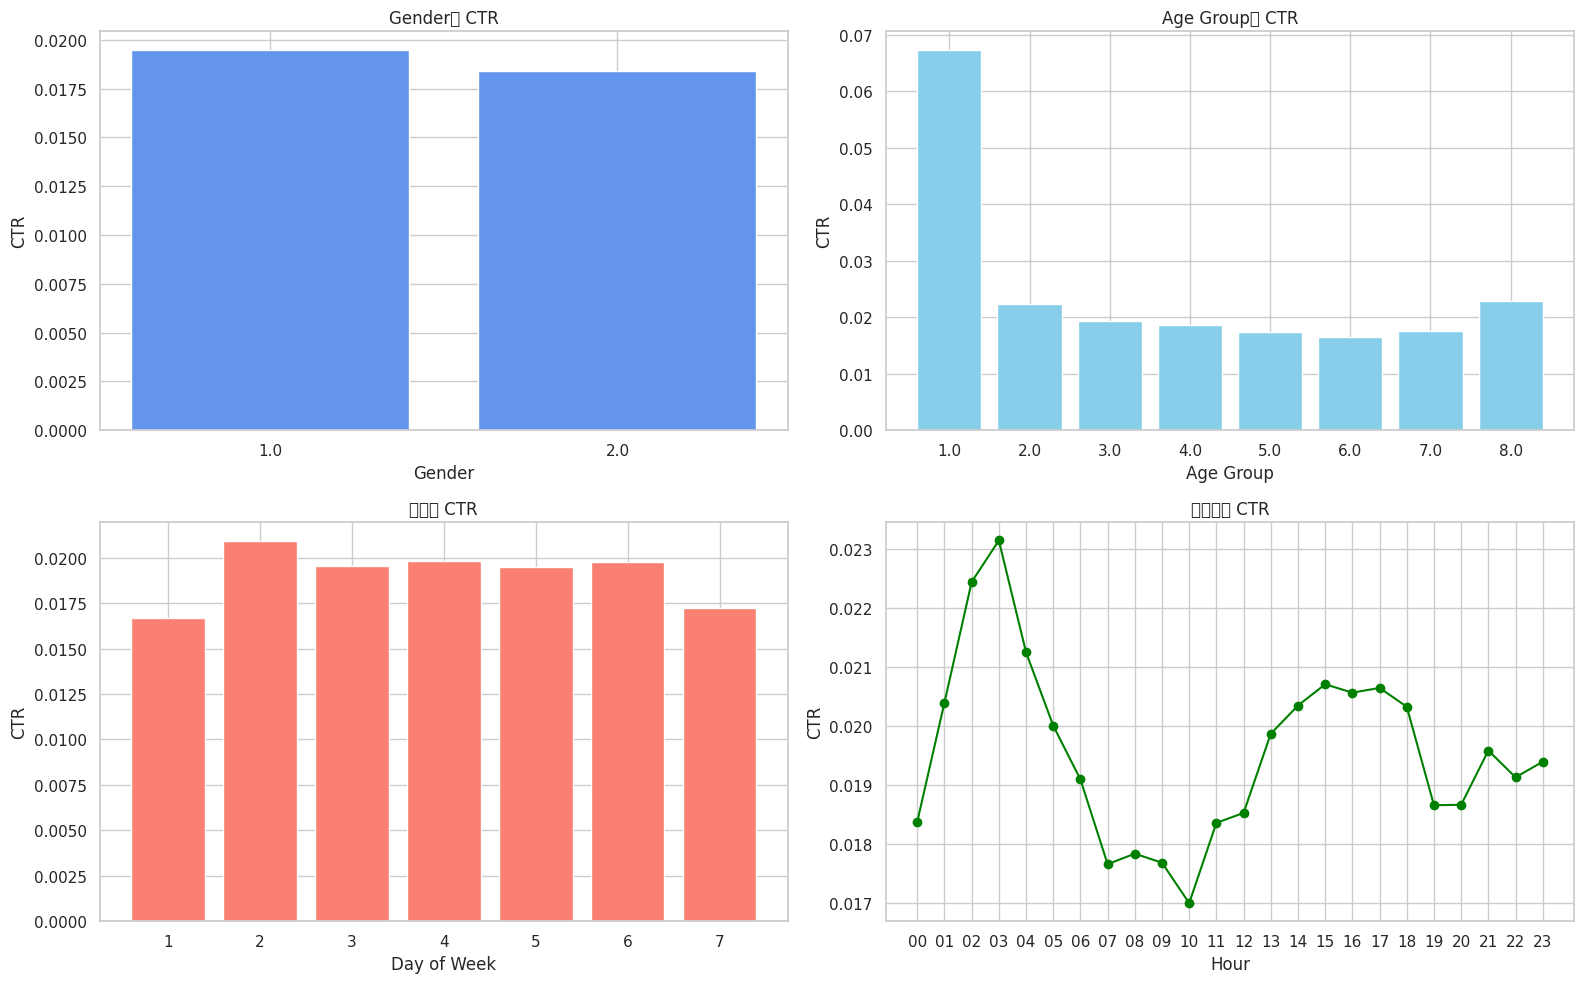

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (16, 10)

# CTR 계산
ctr_gender = train.groupby("gender")["clicked"].mean()
ctr_age    = train.groupby("age_group")["clicked"].mean()
ctr_day    = train.groupby("day_of_week")["clicked"].mean()
ctr_hour   = train.groupby("hour")["clicked"].mean()

# Subplots
fig, axes = plt.subplots(2, 2)

# 1. Gender
axes[0, 0].bar(ctr_gender.index.astype(str), ctr_gender.values, color="cornflowerblue")
axes[0, 0].set_title("Gender별 CTR")
axes[0, 0].set_xlabel("Gender")
axes[0, 0].set_ylabel("CTR")

# 2. Age Group
axes[0, 1].bar(ctr_age.index.astype(str), ctr_age.values, color="skyblue")
axes[0, 1].set_title("Age Group별 CTR")
axes[0, 1].set_xlabel("Age Group")
axes[0, 1].set_ylabel("CTR")

# 3. Day of Week
axes[1, 0].bar(ctr_day.index.astype(str), ctr_day.values, color="salmon")
axes[1, 0].set_title("요일별 CTR")
axes[1, 0].set_xlabel("Day of Week")
axes[1, 0].set_ylabel("CTR")

# 4. Hour (line plot)
axes[1, 1].plot(ctr_hour.index.astype(str), ctr_hour.values, marker="o", color="green")
axes[1, 1].set_title("시간대별 CTR")
axes[1, 1].set_xlabel("Hour")
axes[1, 1].set_ylabel("CTR")
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()